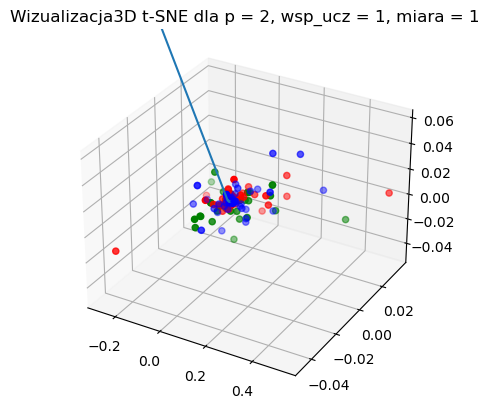

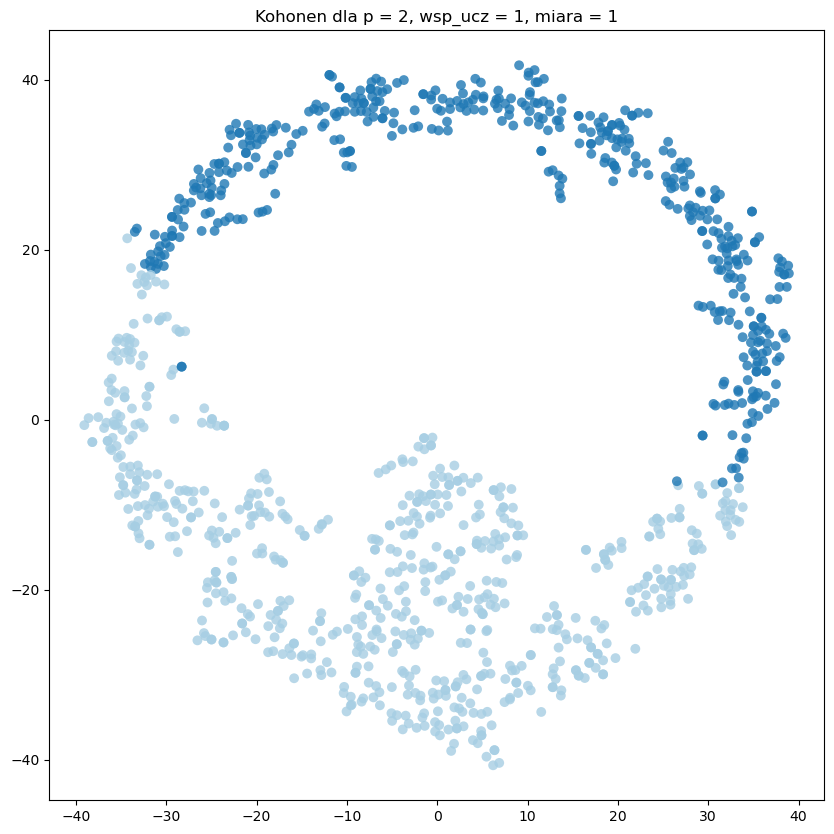

<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import pandas as pd
import numpy.random as nrandom
import matplotlib.pyplot as plt
import seaborn as sea
import math, os
from sklearn.metrics import davies_bouldin_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler

def Kohonen(X, T, alfa, p, wsp_ucz, miara, C1, C2, std):
    #if std True standaryzacja danych (punkt 2.1)
    if std:
        X_std = []
        sum_x = 0

        for i in range(len(X)):
            sum_x = sum_x + X[i]
        
        sr = sum_x/len(X)

        for i in range(len(X)):
            X_std.append((sr - X[i])/np.linalg.norm(sr-X[i]))
        
        X_std = np.array(X_std)
        X = X_std
    
    # inicjalizacja oraz normalizacja wektorów reprezentantów (punkt 2.2)
    vector = []
    rand_gen = np.random.RandomState(0)

    for j in range(p):
        for i in range(len(X)):
            vector_temp = rand_gen.normal(loc=0.0, scale=0.01, size=len(X[0]))
            vector.append(vector_temp/np.linalg.norm(vector_temp))
            
        wek_rep = np.array(vector)
    
    # wybor jednej z 3 miar
    m_table = [0]*len(X)
    alfa_koh = alfa
    for i in range(T):
        if miara == 1:
            modyfikacja = miara1(X, i, p, wek_rep)
            m_table[i%len(X)] = modyfikacja

        if miara == 2:
            modyfikacja = miara2(X, i, p, wek_rep)
            m_table[i%len(X)] = modyfikacja

        if miara == 3:
            modyfikacja = miara3(X, i, p, wek_rep)
            m_table[i%len(X)] = modyfikacja

        # modyfikacja wektorów reprezentantów wg wzorów
        wek_rep[modyfikacja] = wek_rep[modyfikacja] + alfa_koh * (X[i%len(X)] - wek_rep[modyfikacja])
        wek_rep[modyfikacja] = wek_rep[modyfikacja] / np.linalg.norm(wek_rep[modyfikacja])

        # wybor jednego z 3 wspolczynnikow uczenia

        # liniowe zmniejszanie
        if wsp_ucz == 1:
            alfa_koh = alfa*(T-i)/T 
        
        # wykładnicze zmniejszanie
        if wsp_ucz == 2:
            alfa_koh = alfa*math.exp(-C1*i) 
        
        # hiperboliczne zmniejszanie
        if wsp_ucz == 3:
            alfa_koh = C1/(C2+i) 

    return wek_rep, m_table, X

def miara1(X, T_value, p, wek_rep): #miara (3)
    miary = []
    for i in range(p):
        miary.append(np.dot(wek_rep[i], X[T_value % len(X)]))
    
    max_index = np.where(miary == np.amax(miary))
    return max_index[0][0]

def miara2(X, T_value, p, wek_rep): #miara (4)
    miary = []
    for i in range(p):
        miary.append(np.linalg.norm(wek_rep[i] - X[T_value % len(X)]))
    
    max_index = np.where(miary == np.amin(miary))
    return max_index[0][0]

def miara3(X, T_value, p, wek_rep): #miara (5)
    miary = []
    for i in range(p):
        sum_pom = 0
        for j in range(len(wek_rep[0])):
            sum_pom += abs(wek_rep[i][j] - X[T_value % len(X)][j])
        miary.append(math.sqrt(sum_pom))
    
    max_index = np.where(miary == np.amin(miary))
    return max_index[0][0]

# Wyznaczanie liczby klastrów Davies-Bouldin
def best_number_of_class(X, N):
    P = []
    for p in range(2,N):
        wek_rep, tab_m, X_koh = Kohonen(X, 20000, 0.1, p, 1, 1, 1, 1, True)
        result = davies_bouldin_score(X, tab_m)
        P.append(result)
    print(P)
df = pd.read_csv('WineQT.csv', header=None, skiprows=1)

#df = pd.read_csv('WineQT.csv', header = None)
df.columns = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality','Id']
X = df[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']].astype(float).values
y = pd.factorize(df['quality'])[0]



# df = pd.read_csv('iris.data', header = None)
# df.columns = ['SepalLenght', 'SepalWidth', 'PetalLenght', 'PetalWidth', 'Class']
# X = df[['SepalLenght', 'SepalWidth', 'PetalLenght', 'PetalWidth']].values
# y = pd.factorize(df['Class'])[0]

best_number_of_class(X, 5)
for p in range(2,3):
    for j in range(1,2):
        for i in range(1,2):
            koh, predicts, X_koh = Kohonen(X, 20000, 0.1, p, i, j, 0.3, 0.4, True)
                                # Kohonen(X, T, alfa, p, wsp_ucz, miara, C1, C2, std)
            predicts_np = np.array(predicts)
            title3d= "Wizualizacja3D t-SNE dla p = " + str(p) + ", wsp_ucz = " + str(i) + ", miara = " + str(j)
            
            title = "Kohonen dla p = " + str(p) + ", wsp_ucz = " + str(i) + ", miara = " + str(j)
            srodek = [0,0,0]
            fig = plt.figure()
            ax = fig.add_subplot(projection = '3d')

            u1, v1, w1 = zip(srodek, srodek, srodek)
            u2, v2, w2 = zip(koh[0, 0:3], koh[1, 0:3], koh[2, 0:3])
            ax.quiver(u1, v1, w1, u2, v2, w2)
            ax.scatter(X_koh[0:49,0], X_koh[0:49,1], X_koh[0:49,2], c='r') 
            ax.scatter(X_koh[50:99,0], X_koh[50:99,1], X_koh[50:99,2], c='g') 
            ax.scatter(X_koh[100:149,0], X_koh[100:149,1], X_koh[100:149,2], c='b') 
            plt.title(title3d)
            plt.savefig(title3d + ".png")
            # plt.show()


            tsne_tab= TSNE(random_state=0).fit_transform (X_koh)
            plt.figure(figsize=(10,10))
            plt.scatter(tsne_tab[:,0], tsne_tab[:,1], lw= 0, s=50, alpha=0.8, edgecolors='black', c = np.array(sea.color_palette ("Paired")) [predicts_np.astype(int)])
            plt.title(title)
            plt.savefig(title + ".png")
            plt.show()
            plt.clf()
